<a href="https://colab.research.google.com/github/Sarathismg/IST526_Assignment_5/blob/main/Q8_Usage_statistics_of_words_in_different_times.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Essential Libraries

In [51]:
import numpy as np
import pandas as pd

# Plotting tools
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


## Import Plotly

In [52]:
# Using plotly.express
import plotly.express as px
import plotly.graph_objects as go

## Natural Language Processing (NLP) Libraries


In [53]:
import re
from pprint import pprint

import csv
import string

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# spacy for lemmatization
import spacy


### Gensim package

In [54]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Word2Vec

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

### pyLDAVis package

In [55]:
!pip install pyLDAvis

In [56]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()


### NLTK Package

In [57]:
# NLTK Stop words
import nltk
nltk.download("stopwords")
# nltk.download()

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

from nltk import ngrams
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Mount Google Drive

In [58]:
import os

# mount drive
from google.colab import drive
drive.mount('/content/drive')


# edit this path if needed
my_path = '/content/drive/My Drive/Colab Notebooks/'
# my_path = '/content/drive/My Drive/NLP Code/'

# change to this path
os.chdir(my_path)

# verify present working directory. It should be identical to 'my_path'
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks


# Import Text Data

In [59]:
cd MyDrive/

[Errno 2] No such file or directory: 'MyDrive/'
/content/drive/MyDrive


In [60]:
df = pd.read_csv('data/news_articles.csv', encoding='latin-1')
display(df.head())
display(df.tail())

,Article,Date,Heading,NewsType
0,KARACHI: The Sindh government has decided to b...,1/1/2015,sindh govt decides to cut public transport far...,business
1,HONG KONG: Asian markets started 2015 on an up...,1/2/2015,asia stocks up in new year trad,business
2,HONG KONG: Hong Kong shares opened 0.66 perce...,1/5/2015,hong kong stocks open 0.66 percent lower,business
3,HONG KONG: Asian markets tumbled Tuesday follo...,1/6/2015,asian stocks sink euro near nine year,business
4,NEW YORK: US oil prices Monday slipped below $...,1/6/2015,us oil prices slip below 50 a barr,business


,Article,Date,Heading,NewsType
2687,strong>DUBAI: Dubai International Airport and ...,3/25/2017,Laptop ban hits Dubai for 11m weekend traveller,business
2688,"strong>BEIJING: Former Prime Minister, Shaukat...",3/26/2017,Pak China relations not against any third coun...,business
2689,strong>WASHINGTON: Uber has grounded its fleet...,3/26/2017,Uber grounds self driving cars after accid,business
2690,strong>BEIJING: The New Development Bank plans...,3/27/2017,New Development Bank plans joint investments i...,business
2691,strong>KARACHI: Karachi-based technology incub...,3/27/2017,Google powered Startup Weekend energizing prou...,business


# Tokenize: Parse each sentence to words/terms/tokens

In [61]:
df['token'] = df['Article'].apply (lambda x: gensim.utils.simple_preprocess(str(x), deacc=True))
display(df.head())

,Article,Date,Heading,NewsType,token
0,KARACHI: The Sindh government has decided to b...,1/1/2015,sindh govt decides to cut public transport far...,business,"[karachi, the, sindh, government, has, decided..."
1,HONG KONG: Asian markets started 2015 on an up...,1/2/2015,asia stocks up in new year trad,business,"[hong, kong, asian, markets, started, on, an, ..."
2,HONG KONG: Hong Kong shares opened 0.66 perce...,1/5/2015,hong kong stocks open 0.66 percent lower,business,"[hong, kong, hong, kong, shares, opened, perce..."
3,HONG KONG: Asian markets tumbled Tuesday follo...,1/6/2015,asian stocks sink euro near nine year,business,"[hong, kong, asian, markets, tumbled, tuesday,..."
4,NEW YORK: US oil prices Monday slipped below $...,1/6/2015,us oil prices slip below 50 a barr,business,"[new, york, us, oil, prices, monday, slipped, ..."


# Making Bigram and Trigram models

In [62]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(df['token'], min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[df['token']], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


# Remove Stop words

## Define stop word removal functions

In [63]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    nlp = spacy.load('en', disable=['parser', 'ner'])
    
    # allowed_list = ['jaws']
    """https://spacy.io/api/annotation"""
    
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        #texts_out.append([token for token in doc if token.pos_ in allowed_postags])
    return texts_out

## Now, use stop word removal functions

In [64]:
display('before: ', df['token'].head())

'before: '

0    [karachi, the, sindh, government, has, decided...
1    [hong, kong, asian, markets, started, on, an, ...
2    [hong, kong, hong, kong, shares, opened, perce...
3    [hong, kong, asian, markets, tumbled, tuesday,...
4    [new, york, us, oil, prices, monday, slipped, ...
Name: token, dtype: object

In [65]:
# Remove Stop Words
df['token'] = remove_stopwords(df['token'])

# Form Bigrams
# df['token'] = make_bigrams(df['token'])

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en


# Do lemmatization keeping only noun, adj, vb, adv
df['token'] = lemmatization(df['token'], allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [66]:
display('after: ' ,df['token'].head())

'after: '

0    [government, decide, bring, public, transport,...
1    [market, start, upswe, limited, trading, mainl...
2    [share, open, percent, low, follow, tepid, lea...
3    [tumble, follow, painful, loss, sit, year, low...
4    [oil, price, slip, barrel, first, time, year, ...
Name: token, dtype: object

# Creating Corpus and Vocubulary

In [67]:
# Create Dictionary
id2word = corpora.Dictionary(df['token'])

# Create Corpus
texts = df['token']

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
# print(corpus[:1])
# id2word[0]

In [68]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('abide', 1),
  ('add', 1),
  ('applicable', 1),
  ('bring', 1),
  ('cent', 1),
  ('charge', 1),
  ('commuter', 1),
  ('compare', 1),
  ('compress', 1),
  ('country', 1),
  ('cut', 1),
  ('decide', 1),
  ('decision', 1),
  ('decrease', 1),
  ('due', 1),
  ('fare', 4),
  ('federal', 1),
  ('gas', 1),
  ('government', 3),
  ('irshad', 1),
  ('low', 1),
  ('make', 1),
  ('massive', 1),
  ('mean', 1),
  ('meanwhile', 1),
  ('natural', 1),
  ('news', 1),
  ('part', 1),
  ('pc', 1),
  ('petroleum', 1),
  ('price', 2),
  ('product', 1),
  ('public', 2),
  ('reduction', 2),
  ('refuse', 1),
  ('report', 1),
  ('rickshaw', 1),
  ('run', 1),
  ('say', 3),
  ('source', 1),
  ('taxi', 1),
  ('transport', 2),
  ('transporter', 1),
  ('travel', 1),
  ('vehicle', 1)]]

# Build LDA Model

In [69]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=15, 
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

In [70]:
# Print the Keyword in the 10 topics
# pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

In [71]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=df['token'], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.521265219557464

Coherence Score:  0.44372062265071704


# Making Word2Vec Model

## Printing the corpus

In [72]:
display(texts)

0       [government, decide, bring, public, transport,...
1       [market, start, upswe, limited, trading, mainl...
2       [share, open, percent, low, follow, tepid, lea...
3       [tumble, follow, painful, loss, sit, year, low...
4       [oil, price, slip, barrel, first, time, year, ...
                              ...                        
2687    [flag, carrier, begin, implement, ban, laptop,...
2688    [strong, former, say, stand, test, time, count...
2689    [ground, fleet, self, drive, car, pende, inves...
2690    [strong, plan, co, finance, infrastructure, pr...
2691    [strong, base, technology, incubator, organize...
Name: token, Length: 2692, dtype: object

## Training word2vec model

In [73]:
w2vmodel = Word2Vec(texts, size=32, window=5, min_count=5, workers=4)

In [74]:
list_1 = w2vmodel.wv.most_similar('use',topn=10)
# list_2 = w2vmodel.wv.most_similar('problems',topn=100)

word_list_1 = []

for l in list_1:
    word_list_1.append(l[0])
print(word_list_1)

['provide', 'technology', 'governance', 'offer', 'exclusively', 'service', 'opportunity', 'access', 'ambassador', 'education']


## Visualizing w2v

In [75]:
from sklearn.manifold import TSNE

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model   = TSNE(perplexity=50, n_components=2, n_iter=2500, random_state=0)
    reduced_dims = tsne_model.fit_transform(tokens)

    # get the cooridinates
    x = reduced_dims[:, 0]
    y = reduced_dims[:, 1]
    
    # note that animation_group should exist in all frames
    fig = px.scatter(
      # data_frame = df_country, 
      x= x,       
      y=y,        
      hover_name=labels,
      # log_x=True, 
      size_max=55, 
      text = labels,
      range_x=[-50, 50], 
      range_y=[-50,50],
      width = 1000,
      height = 1000,
      title= "t-SNE visualization of words", 
    )

    fig.update_traces(textposition='top center')

    fig.show()
# pass

In [76]:
tsne_plot(w2vmodel)

# Word Cloud

In [77]:
from collections import Counter

words = df.token.sum()
word_freq = Counter(words)

print(word_freq.most_common(100))

[('say', 6599), ('year', 3641), ('percent', 3304), ('strong', 2330), ('first', 2110), ('last', 1945), ('also', 1945), ('price', 1854), ('oil', 1814), ('market', 1806), ('make', 1743), ('take', 1602), ('would', 1549), ('team', 1504), ('day', 1469), ('match', 1463), ('test', 1458), ('run', 1373), ('month', 1372), ('time', 1358), ('play', 1357), ('world', 1260), ('week', 1250), ('wicket', 1237), ('country', 1219), ('high', 1200), ('add', 1141), ('second', 1085), ('fall', 1041), ('come', 1022), ('ball', 1016), ('rise', 1003), ('could', 961), ('low', 948), ('go', 925), ('crude', 917), ('government', 916), ('player', 908), ('see', 878), ('rate', 872), ('global', 818), ('final', 817), ('good', 814), ('early', 813), ('dollar', 801), ('lead', 800), ('cricket', 782), ('include', 775), ('game', 774), ('give', 768), ('get', 766), ('start', 763), ('win', 755), ('new', 749), ('point', 748), ('expect', 747), ('end', 742), ('leave', 741), ('barrel', 740), ('tell', 737), ('score', 712), ('increase', 70

(-0.5, 1599.5, 799.5, -0.5)

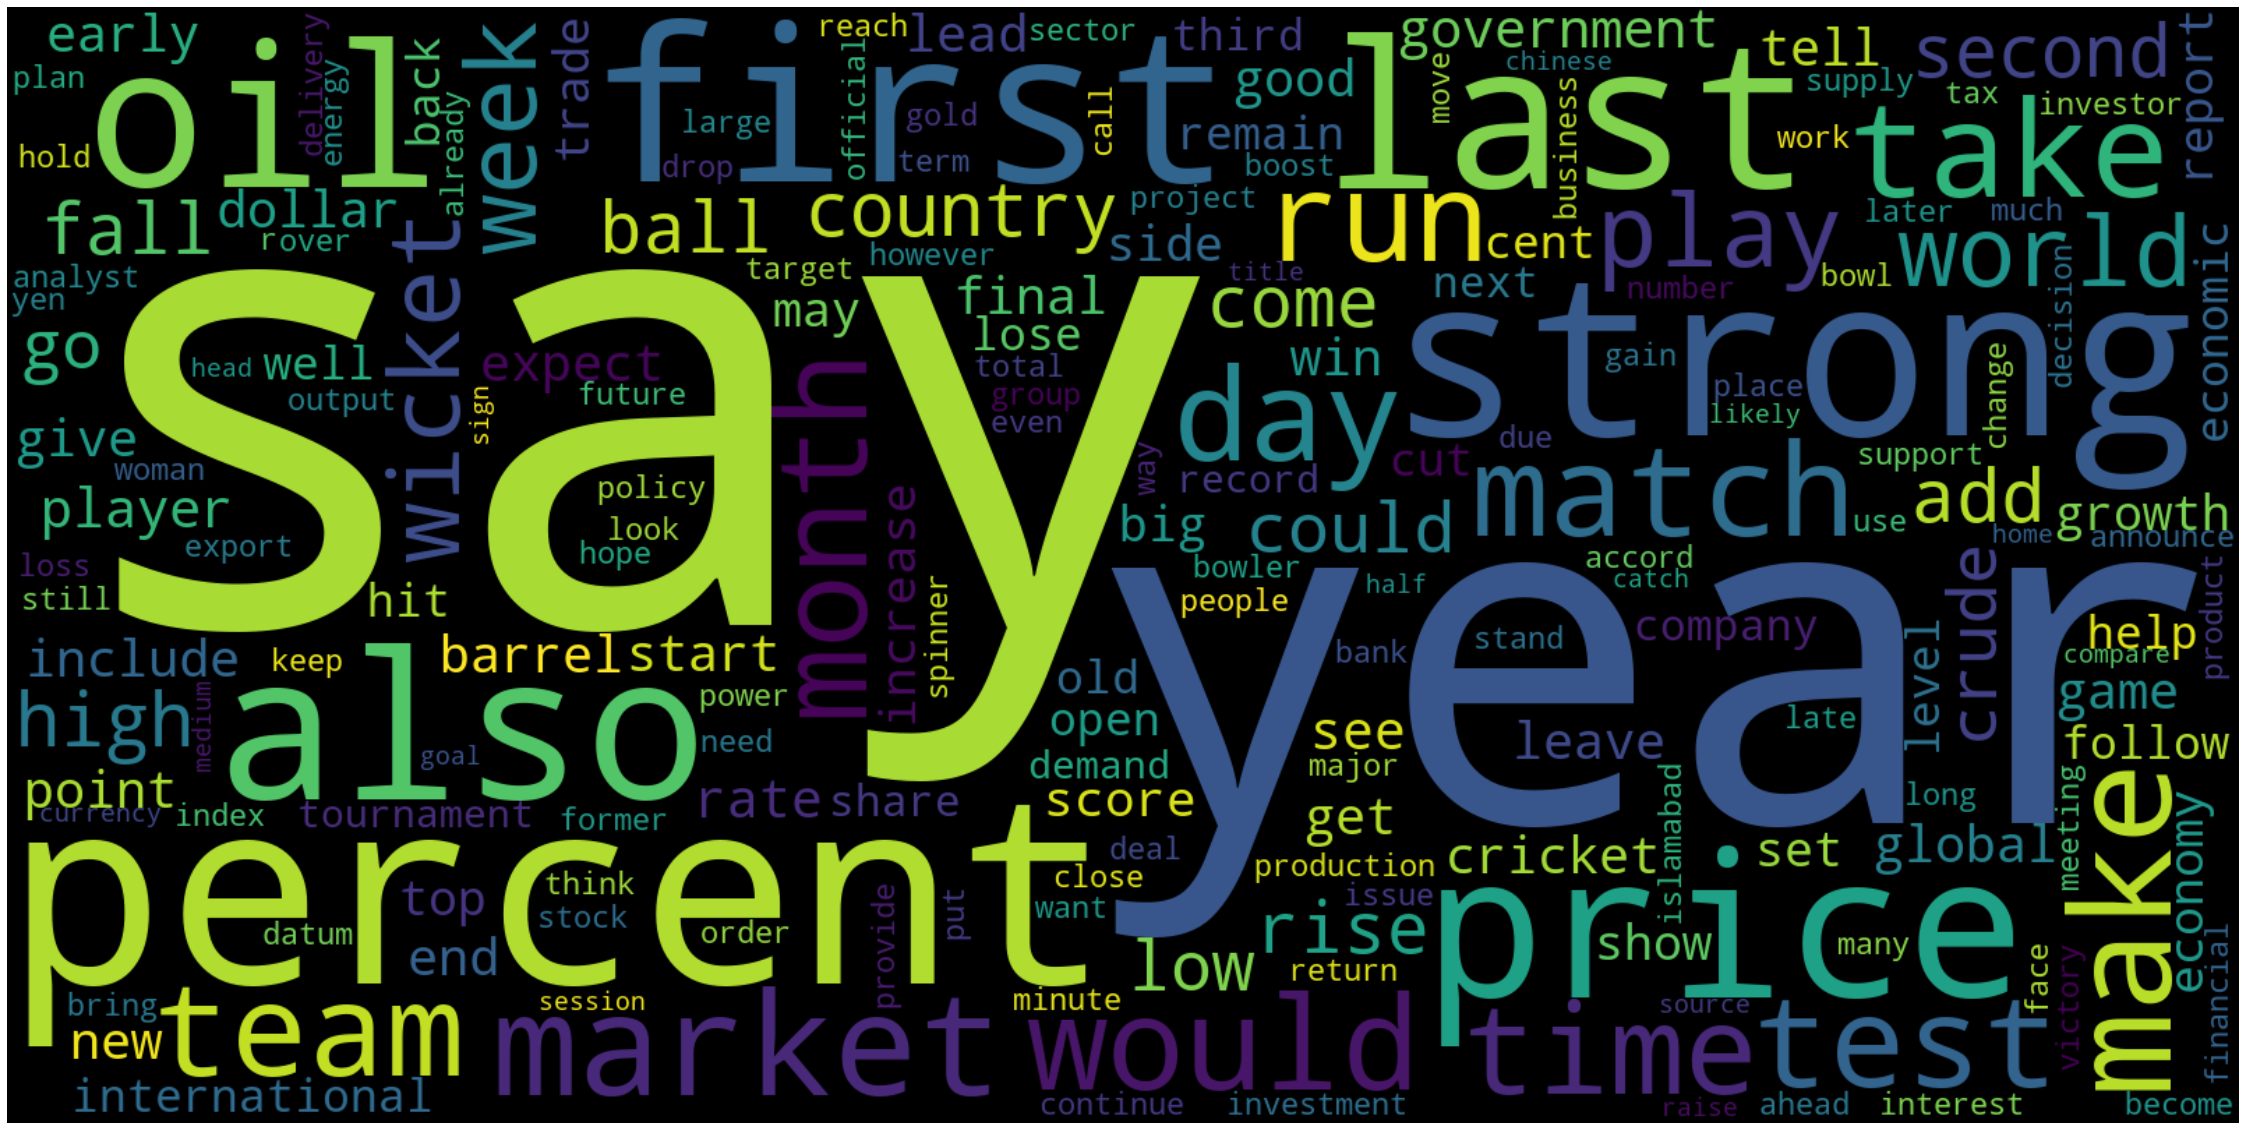

In [78]:
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(width=1600, height=800)


wordcloud.generate_from_frequencies(frequencies=word_freq)

mpl.rcParams['figure.figsize']=(40.0,30.0)    #(6.0,4.0)
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=3000             #72 
mpl.rcParams['figure.subplot.bottom']=.1 

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# Usage Pattern of a word over different month-year

In [201]:
target_word = 'oil'


In [202]:
freqs = []
# take the number of times that word appeared
for k in range(len(df['token'])):
  freqs.append(df['token'][k].count(target_word))

In [203]:
import pandas as pd
df['freqs'] = freqs
df['my'] = pd.to_datetime(df['Date']).dt.to_period('M')

In [204]:
# month year basis grouping to identify the usage pattern
df2 = df.groupby('my')
keys = df2.groups.keys()
vals = df2.sum()
vals = vals['freqs']
vals = vals.values
all_keys = [str(k) for k in list(keys)]

# Now we have both keys and values. We can plot them

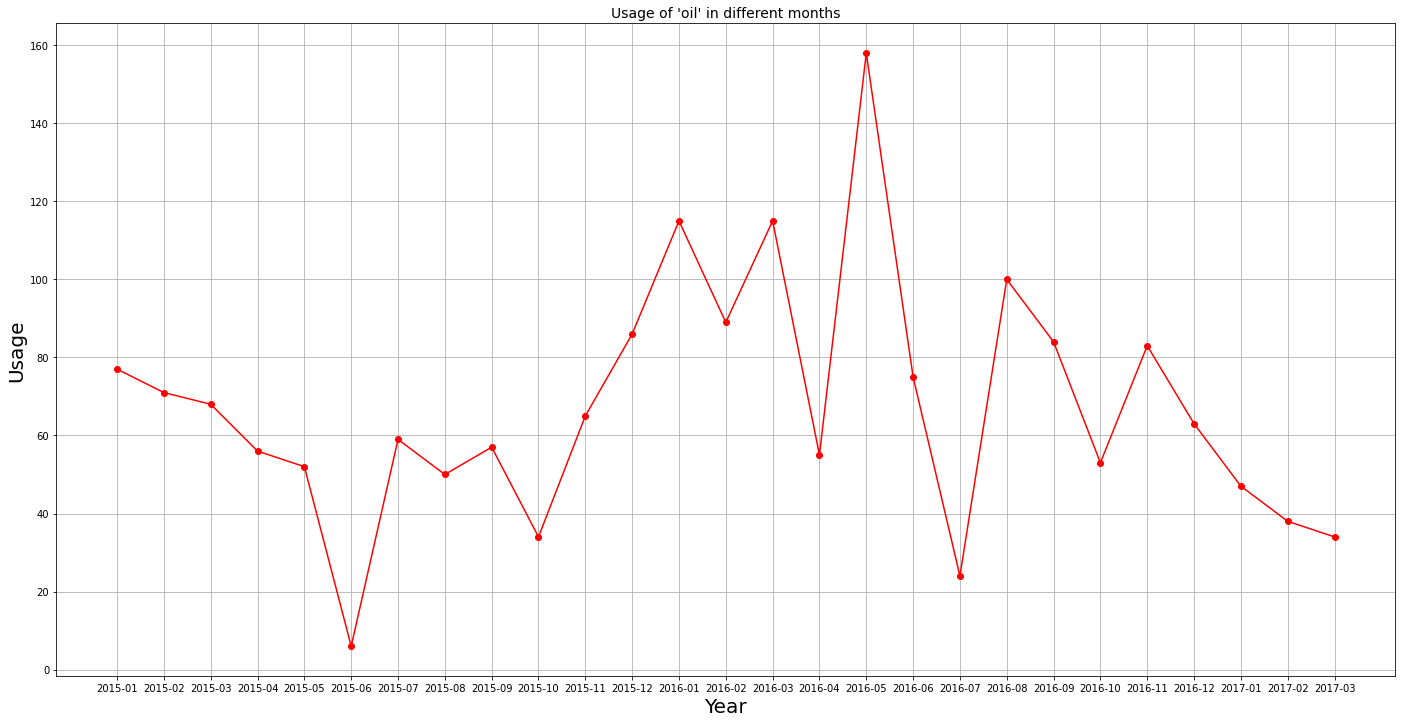

In [205]:
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 12))
plt.plot(all_keys, vals, color='red', marker='o')
plt.title('Usage of \'' + target_word + '\' in different months', fontsize=14)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Usage', fontsize=20)
plt.grid(True)
plt.show()